In [244]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import torch
import torch.nn as  nn
import torch.optim as optim

from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler


In [245]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [246]:
ticker  = 'NVDA'

df = yf.download(ticker,'2015-01-01')

df

C:\Users\Aamir Bin Abbas\AppData\Local\Temp\ipykernel_21832\584317781.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker,'2015-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2015-01-02,0.483066,0.486665,0.475386,0.483066,113680000
2015-01-05,0.474906,0.484505,0.472747,0.483066,197952000
2015-01-06,0.460508,0.476106,0.460028,0.475626,197764000
2015-01-07,0.459308,0.467947,0.457868,0.463868,321808000
2015-01-08,0.476586,0.479466,0.464348,0.464588,283780000
...,...,...,...,...,...
2025-09-02,170.779999,172.380005,167.220001,170.000000,231164900
2025-09-03,170.619995,172.410004,168.880005,171.059998,164424900


<Axes: xlabel='Date'>

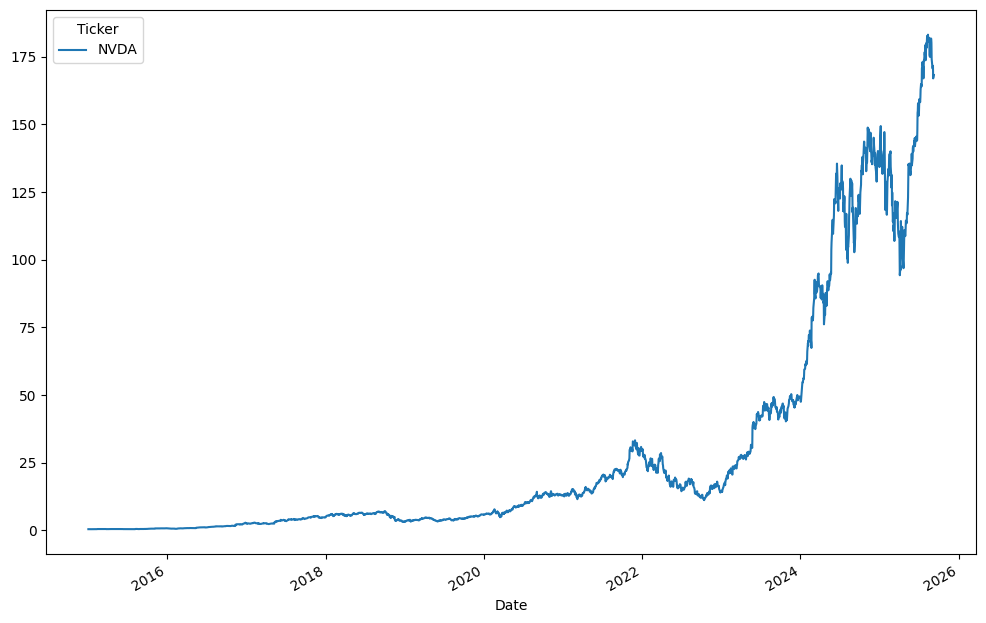

In [247]:
df.Close.plot(figsize= (12,8))

In [248]:
scalar = StandardScaler()

df['Close'] = scalar.fit_transform(df['Close'].values.reshape(-1,1))

In [249]:
df.Close

Ticker,NVDA
Date,
2015-01-02,-0.646237
2015-01-05,-0.646427
2015-01-06,-0.646762
2015-01-07,-0.646789
2015-01-08,-0.646388
...,...
2025-09-02,3.309802
2025-09-03,3.306086
2025-09-04,3.330245


In [250]:
seq_length =30
data = []

for i in range(len(df) - seq_length):
    data.append(df.Close[i:i+seq_length])

data = np.array(data)

data.shape

(2656, 30, 1)

In [251]:

train_size = int(0.8 * len(data))

X_train = torch.from_numpy(data[:train_size,:-1,:]).float().to(device)
y_train = torch.from_numpy(data[:train_size,-1,:]).float().to(device)

X_test = torch.from_numpy(data[train_size:,:-1,:]).float().to(device)
y_test = torch.from_numpy(data[train_size:,-1,:]).float().to(device)
   

In [252]:
y_test

tensor([[0.4030],
        [0.3978],
        [0.4082],
        [0.4279],
        [0.4274],
        [0.4222],
        [0.3703],
        [0.3760],
        [0.3798],
        [0.3969],
        [0.3795],
        [0.3305],
        [0.3266],
        [0.2910],
        [0.3583],
        [0.3627],
        [0.3521],
        [0.3488],
        [0.3478],
        [0.4329],
        [0.4028],
        [0.4364],
        [0.4375],
        [0.4109],
        [0.4299],
        [0.4751],
        [0.4863],
        [0.4884],
        [0.4687],
        [0.4696],
        [0.4352],
        [0.4162],
        [0.4006],
        [0.3915],
        [0.3843],
        [0.3986],
        [0.4008],
        [0.3618],
        [0.3633],
        [0.3530],
        [0.3232],
        [0.2949],
        [0.3086],
        [0.3228],
        [0.3156],
        [0.3286],
        [0.3430],
        [0.3525],
        [0.3823],
        [0.3529],
        [0.3651],
        [0.3801],
        [0.4050],
        [0.3937],
        [0.4059],
        [0

In [253]:
y_train

tensor([[-0.6450],
        [-0.6450],
        [-0.6451],
        ...,
        [ 0.3993],
        [ 0.3712],
        [ 0.3783]], device='cuda:0')

In [254]:
class PredictionModel(nn.Module):
    def __init__(self, input_dim,hidden_dim,num_layers,output_dim):
        super(PredictionModel,self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True,dropout=0.2)
        
        self.fc = nn.Linear(hidden_dim,output_dim)
        
    def forward(self,x):
        h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_dim,device=device)
        c0 = torch.zeros(self.num_layers,x.size(0),self.hidden_dim,device=device)    
            
        out,(hn,cn) = self.lstm(x,(h0.detach(),c0.detach()))
        
        out = self.fc(out[:,-1,:])
        
        return out

In [255]:
model = PredictionModel(input_dim=1,hidden_dim=32,num_layers=2,output_dim=1).to(device)

In [256]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [257]:
num_epochs = 500

for i in range(num_epochs):
    y_train_pred = model(X_train)
    
    loss = criterion(y_train_pred,y_train)
    
    if i % 10 ==0:
        print(i,loss.item())
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
        
         

0 0.2472156584262848
10 0.13339535892009735
20 0.04717108979821205
30 0.04410906508564949
40 0.038474541157484055
50 0.03324175998568535
60 0.029316145926713943
70 0.022753311321139336
80 0.01306924782693386
90 0.0070753684267401695
100 0.006687416695058346
110 0.005271729547530413
120 0.004486114252358675
130 0.0035829220432788134
140 0.002929645124822855
150 0.002354823984205723
160 0.0019098547054454684
170 0.001789440750144422
180 0.00159759062808007
190 0.0014244456542655826
200 0.0013385489583015442
210 0.0012792072957381606
220 0.0012419254053384066
230 0.0011151937069371343
240 0.001066878903657198
250 0.001105456962250173
260 0.001013129367493093
270 0.0010546717094257474
280 0.0010029880795627832
290 0.0009844852611422539
300 0.000905077438801527
310 0.0009447577176615596
320 0.0008951595518738031
330 0.0008954810327850282
340 0.0008838060894049704
350 0.000878634920809418
360 0.0008600159781053662
370 0.0008409987203776836
380 0.000822284899186343
390 0.0008402782259508967
4

In [258]:
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train)
    y_test_pred = model(X_test)

# Convert to NumPy
y_train_pred_np = y_train_pred.detach().cpu().numpy()
y_test_pred_np = y_test_pred.detach().cpu().numpy()

# Convert labels to NumPy if they are tensors
y_train_np = y_train.detach().cpu().numpy() if torch.is_tensor(y_train) else y_train
y_test_np = y_test.detach().cpu().numpy() if torch.is_tensor(y_test) else y_test


# Inverse scale
y_train_pred_inv = scalar.inverse_transform(y_train_pred_np)
y_train_inv = scalar.inverse_transform(y_train_np)
y_test_pred_inv = scalar.inverse_transform(y_test_pred_np)
y_test_inv = scalar.inverse_transform(y_test_np)


In [259]:
# RMSE
train_rmse = root_mean_squared_error(y_train_inv, y_train_pred_inv)
test_rmse = root_mean_squared_error(y_test_inv, y_test_pred_inv)

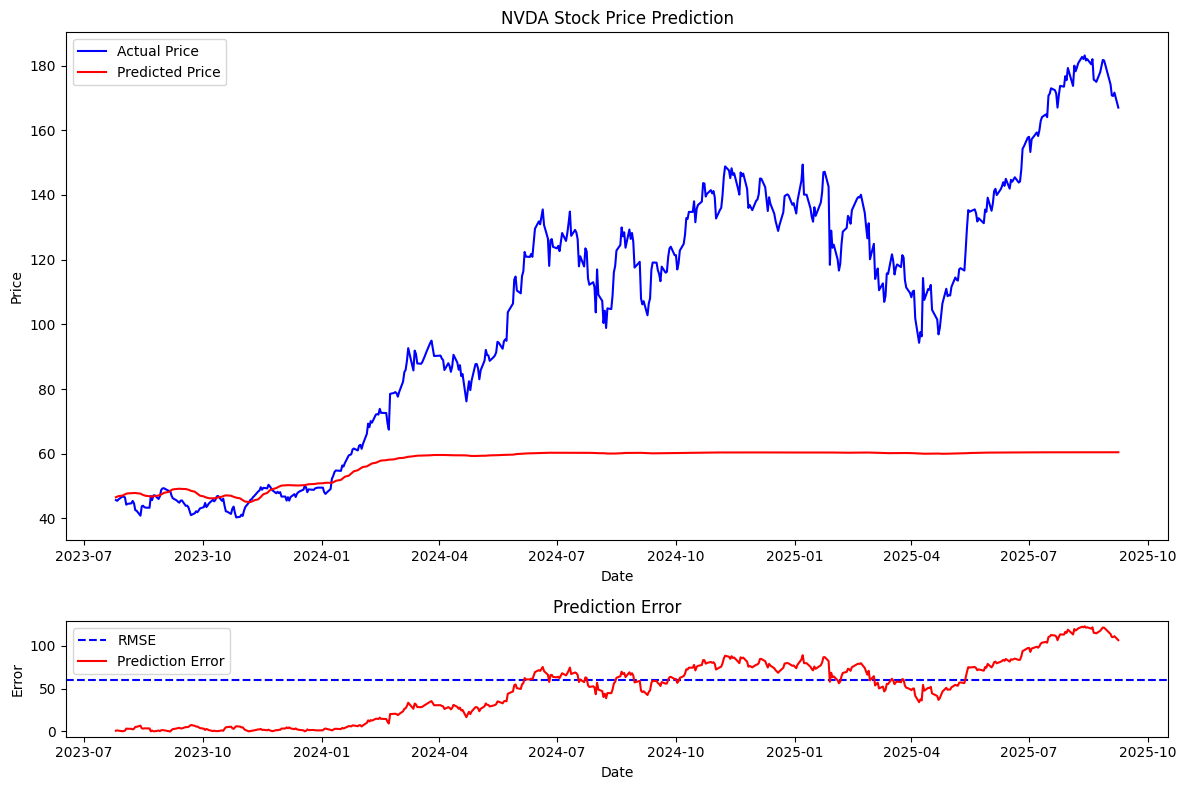

In [260]:
fig =  plt.figure(figsize=(12,8))
gs = fig.add_gridspec(4,1)

ax1 = fig.add_subplot(gs[:3,0])

ax1.plot(df.iloc[-len(y_test_inv):].index, y_test_inv, color='blue', label='Actual Price')
ax1.plot(df.iloc[-len(y_test_pred_inv):].index, y_test_pred_inv, color='red', label='Predicted Price')
ax1.legend()
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')


ax2 = fig.add_subplot(gs[3,0]) 
ax2.axhline(test_rmse,color = 'blue',linestyle='--',label ='RMSE')
ax2.plot(df.iloc[-len(y_test_inv):].index, abs(y_test_inv - y_test_pred_inv), 'r', label='Prediction Error')
ax2.legend()
ax2.set_title('Prediction Error')
plt.xlabel('Date')
plt.ylabel('Error')
plt.tight_layout()


plt.show()
